In [3]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import folium
import pandas as pd
import networkx as nx
from folium.plugins import FeatureGroupSubGroup

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.colors as mcolors



from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
# leer los datos
limpio_2009=pd.read_csv('limpio_2009.csv')
cd=pd.read_csv('airport-codes_csv.csv')

In [5]:
limpio_2009.head()

,Unnamed: 0,FL_DATE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CANCELLED,OP_CARRIER,Date_Time
0,0,2009-01-01,DCA,EWR,11:00,10:58,-2.0,0.0,XE,2009-01-01 11:00:00
1,1,2009-01-01,EWR,IAD,15:10,15:09,-1.0,0.0,XE,2009-01-01 15:10:00
2,2,2009-01-01,EWR,DCA,11:00,10:59,-1.0,0.0,XE,2009-01-01 11:00:00
3,3,2009-01-01,DCA,EWR,12:40,12:49,9.0,0.0,XE,2009-01-01 12:40:00
4,4,2009-01-01,IAD,EWR,17:15,17:05,-10.0,0.0,XE,2009-01-01 17:15:00


# Pagerank y matriz estocastica

In [6]:
#matriz estocastica
frequency_matrix_2009 = pd.crosstab(limpio_2009.ORIGIN,limpio_2009.DEST)
stochastic_matrix_2009 = frequency_matrix_2009.apply(lambda x: x/sum(x),axis=1)
frecs = frequency_matrix_2009.sum()

In [7]:
#Page rank
alpha = .85  
n = stochastic_matrix_2009.shape[0]  
G = alpha * stochastic_matrix_2009 + (1 - alpha) * (np.ones((n, n)) / n)
a = G
for i in range(100):
    a = np.matmul(a,G)
page_rank = np.matmul(np.array([1/290 for i in range(290)]),G)

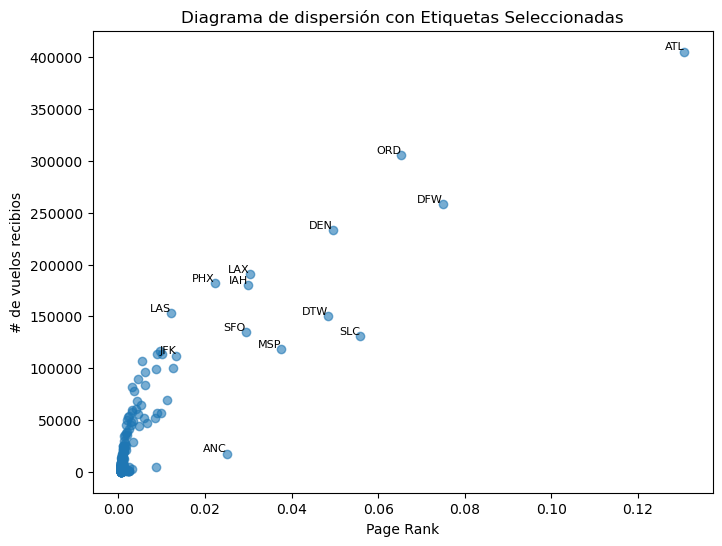

In [8]:
selected_labels = {"DFW", 'PHX',"ATL", "ANC", "LAX", "LAS", "SFO", "MSP", "SLC", "DTW", "DEN", "ORD", "IAH",'INU','JFK'}

# Crear el scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(page_rank, frecs, alpha=0.6)

# Añadir solo las etiquetas seleccionadas
for label in selected_labels:
    if label in page_rank.index:
        plt.text(page_rank[label], frecs[label], label, fontsize=8, ha='right', va='bottom')

# Mostrar la gráfica
plt.xlabel("Page Rank")
plt.ylabel("# de vuelos recibios")
plt.title("Diagrama de dispersión con Etiquetas Seleccionadas")
plt.show()

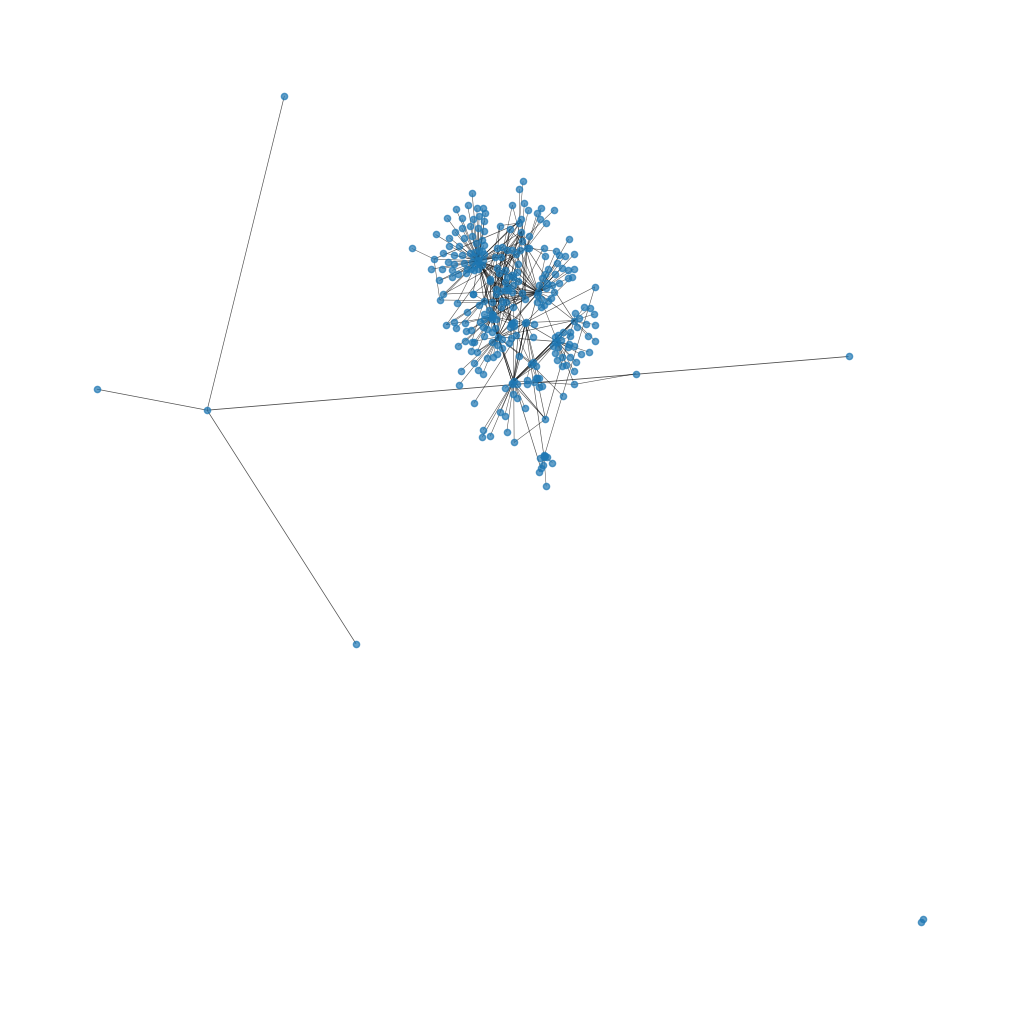

In [9]:
# Construcción del grafo original
Graph = nx.Graph(frequency_matrix_2009)

#Para cada nodo, conservar solo el 10% de sus aristas más pesadas
edges_to_keep = set()

for node in Graph.nodes():
    neighbors = Graph[node]
    if len(neighbors) == 0:
        continue


    neighbor_edges = [(node, nbr, data["weight"]) for nbr, data in neighbors.items()]


    k = max(1, int(len(neighbor_edges) * 0.10))

    top_edges = sorted(neighbor_edges, key=lambda x: x[2], reverse=True)[:k]


    for u, v, w in top_edges:
        edges_to_keep.add(tuple(sorted((u, v))))  # evitar duplicados

#Crear subgrafo con esas aristas
filtered_graph = Graph.edge_subgraph(edges_to_keep).copy()


layout_filtered = nx.kamada_kawai_layout(filtered_graph,scale=5)

#Normalizar pesos de aristas seleccionadas
edge_sizes = np.array(list(nx.get_edge_attributes(filtered_graph, "weight").values()))
edge_sizes = (edge_sizes - edge_sizes.min()) / (edge_sizes.max() - edge_sizes.min() + 1e-5)
edge_sizes = (1 + edge_sizes) * 0.3

#Graficar
plt.figure(figsize=(10, 10))
nx.draw(
    filtered_graph,
    pos=layout_filtered,  
    node_size=20,
    width=edge_sizes,
    alpha=0.7,
    with_labels=False
)

plt.show()

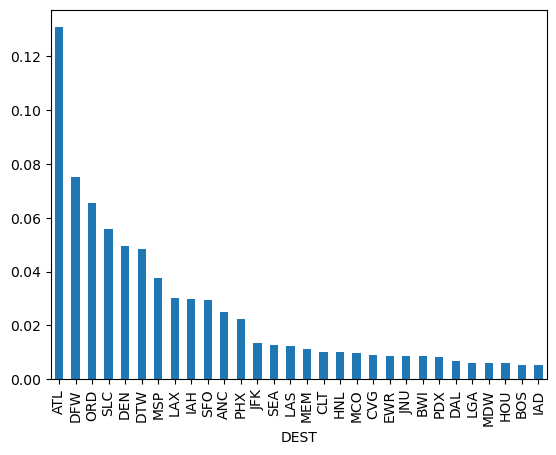

<Axes: xlabel='DEST'>

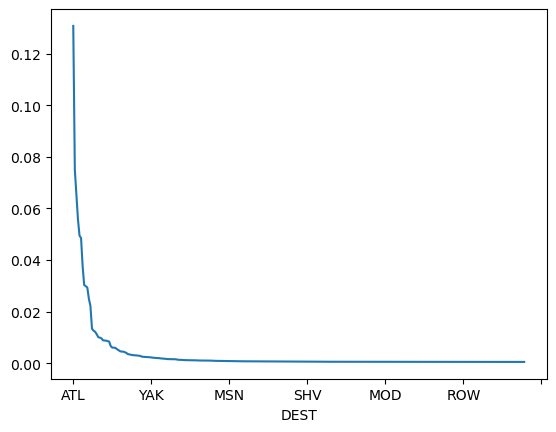

In [10]:
#graficas de valores pr
page_rank.sort_values(ascending=False).head(30).plot.bar()
plt.show()
page_rank.sort_values(ascending=False).plot()

La imagen de Alaska se construye posteriormente.

# Descomposicion de vals

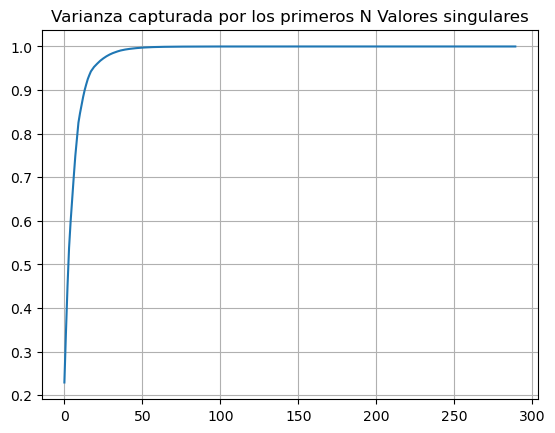

-


<Figure size 640x480 with 0 Axes>

In [11]:

#Hacer SVD
U, S, Vt = np.linalg.svd(stochastic_matrix_2009, full_matrices=False)

#Varianza capturada
explained_variance = np.cumsum(S**2) / np.sum(S**2)

optimal_k = np.argmax(explained_variance >= 0.95) + 1


svd = U[:, :optimal_k] @ np.diag(S[:optimal_k])


svd_df = pd.DataFrame(svd, index=pd.Index(stochastic_matrix_2009.index))
plt.plot(explained_variance)
plt.title('Varianza capturada por los primeros N Valores singulares')
plt.grid()
plt.show()
print('-')

plt.suptitle('Dispersión de los primeros 5 valores singulares', fontsize=14, y=1.02)
plt.show()


In [12]:
# k optima
print(optimal_k)

20


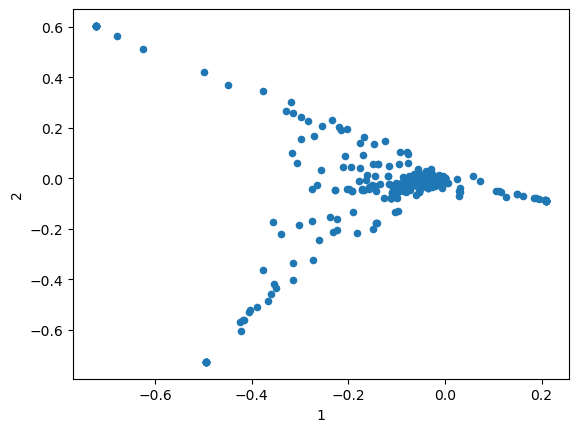

In [13]:
# valores 1 y 2

svd_df.plot.scatter(1,2)
plt.show()

# Agrupamiento de k-medias

c:\Users\cmettah\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\cmettah\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\cmettah\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\cmettah\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:14

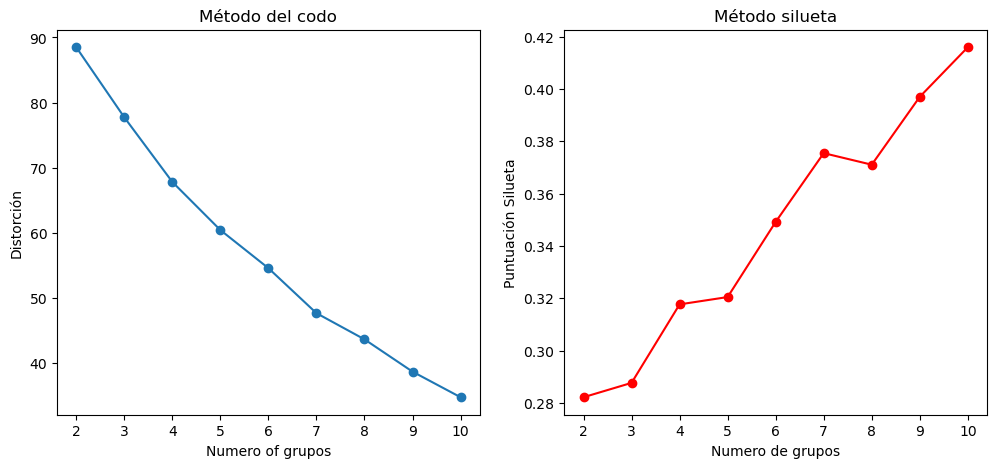

In [14]:
def find_optimal_clusters(data, max_k=10):
    distortions = []
    silhouette_scores = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=33, n_init=10)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

# graficar el metodo del codo
    plt.figure(figsize=(12, 5))
# graficar el método de silueta
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k + 1), distortions, marker='o')
    plt.xlabel("Numero of grupos")
    plt.ylabel("Distorción")
    plt.title("Método del codo")


    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', color='red')
    plt.xlabel("Numero de grupos")
    plt.ylabel("Puntuación Silueta")
    plt.title("Método silueta")

    plt.show()
# Call the function with your SVD-transformed data
find_optimal_clusters(svd_df, max_k=10)



In [15]:

# Número de clusters
n_clusters = 7
# Hacer k-medias
kmeans = KMeans(n_clusters=n_clusters, random_state=33, n_init=10)
kmeans.fit(svd_df)
labels = kmeans.labels_

# Guardar los clusters
clusters = pd.DataFrame([svd_df.index, labels]).transpose().set_index(0).sort_values(by=1)
clusters.rename(columns={1: 'clus'}, inplace=True)
clusters['color'] = clusters['clus'].map({0: 'red', 1: 'green', 2: 'blue'
                                          , 3: 'black', 4: 'orange', 5: 'purple', 
                                          6: 'yellow',7:'brown',8:'black',9:'turquoise'})

svd_df_clus=svd_df.copy()
svd_df_clus['clusters']=clusters['color']

c:\Users\cmettah\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


C:\Users\cmettah\AppData\Local\Temp\ipykernel_36072\2944499442.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


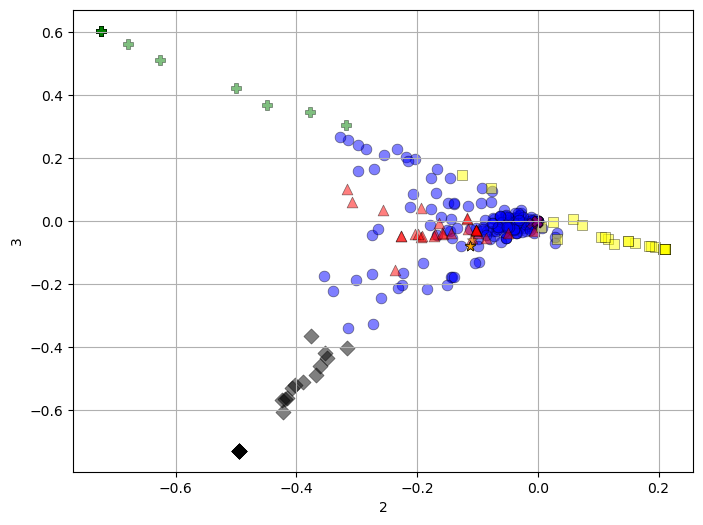

In [16]:

markers = ['o', 's', '^', 'D', 'P', 'X', '*']

# Contar frecuencia de cada cluster y ordenarlos
cluster_counts = svd_df_clus['clusters'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 6))

# Graficar en orden de frecuencia
for i, clus in enumerate(cluster_counts.index):
    subset = svd_df_clus[svd_df_clus['clusters'] == clus]
    plt.scatter(
        subset.iloc[:, 1],   # eje X = columna 1
        subset.iloc[:, 2],   # eje Y = columna 2
        c=[clus],            # color según número de cluster
        cmap='tab10',
        marker=markers[i % len(markers)],  # asignar forma única
        s=60, alpha=0.5,
        edgecolor='black', linewidth=0.5   # borde negro
    )

plt.xlabel(svd_df_clus.columns[1]+1)
plt.ylabel(svd_df_clus.columns[2]+1)


plt.grid(True)
plt.show()

# Mapa de los aeropuertos

In [17]:
svd_df_clus['pagerank']=page_rank

import folium
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io, base64

def plot_airport_network(frequency_matrix_2009, svd_df_clus, cd, 
                         show_clusters=True, show_pagerank=True, show_lines=True):
 
    svd_df_clus = svd_df_clus.copy().reset_index()

    # Separar coordenadas
    cd[['longitude', 'latitude']] = cd['coordinates'].str.split(',', expand=True).astype(float)

    # Aeropuertos relevantes
    airports_in_matrix = set(frequency_matrix_2009.index) | set(frequency_matrix_2009.columns)
    airports_in_cluster = set(svd_df_clus["ORIGIN"])
    cd_filtered = cd[cd['iata_code'].isin(airports_in_matrix | airports_in_cluster)].copy()

    # Matriz larga
    merged_df = frequency_matrix_2009.copy()
    merged_df.index.name = "ORIGIN"
    merged_df = merged_df.reset_index()
    long_df = merged_df.melt(id_vars=["ORIGIN"], var_name="DEST", value_name="frequency")
    long_df = long_df[long_df["frequency"] > 0]

    long_df = long_df.merge(cd_filtered[['iata_code', 'longitude', 'latitude']], 
                            left_on="ORIGIN", right_on="iata_code", how="left")
    long_df = long_df.merge(cd_filtered[['iata_code', 'longitude', 'latitude']], 
                            left_on="DEST", right_on="iata_code", how="left", suffixes=("_origin", "_dest"))
    long_df = long_df.drop(columns=["iata_code_origin", "iata_code_dest"])
    final_df = long_df.merge(svd_df_clus, on="ORIGIN", how="left")

    # Grafo
    Graph = nx.Graph()
    for _, row in svd_df_clus.iterrows():
        if row['ORIGIN'] in cd_filtered['iata_code'].values:
            coord = cd_filtered.loc[cd_filtered['iata_code'] == row['ORIGIN'], ['longitude', 'latitude']].values[0]
            Graph.add_node(
                row['ORIGIN'],
                pos=(coord[0], coord[1]),
                cluster=row['clusters'],   # color string: "blue", "red", etc
                pagerank=row['pagerank']
            )

    for _, row in final_df.iterrows():
        if row["ORIGIN"] in Graph.nodes and row["DEST"] in Graph.nodes:
            Graph.add_edge(row["ORIGIN"], row["DEST"], weight=row["frequency"])

    # Mapa base
    map_center = [cd_filtered['latitude'].mean(), cd_filtered['longitude'].mean()]
    flight_map = folium.Map(location=map_center, zoom_start=5)

    flight_lines_group = folium.FeatureGroup(name="Flight Connections", overlay=True, control=True)
    cluster_group = folium.FeatureGroup(name="Clusters", overlay=True, control=True)
    pagerank_group = folium.FeatureGroup(name="Pagerank (Size)", overlay=True, control=True)

    # Líneas de vuelos
    if show_lines:
        for u, v, data in Graph.edges(data=True):
            start = Graph.nodes[u]['pos']
            end = Graph.nodes[v]['pos']
            folium.PolyLine(
                locations=[[start[1], start[0]], [end[1], end[0]]],
                color="grey",
                weight=np.log(1+data['weight'])/5,
                opacity=.1
            ).add_to(flight_lines_group)


    cluster_markers = {
        "blue": "o",
        "yellow": "s",
        "red": "^",
        "black": "D",
        "green": "P",
        "purple": "X",
        "orange": "*"
    }

    # Generador de íconos base64
    def make_icon(marker, color, size_pts=18):
        fig, ax = plt.subplots(figsize=(0.4,0.4))
        ax.plot(0.5, 0.5, marker=marker, color=color, markersize=size_pts,
                markeredgecolor="black", markeredgewidth=0.5, alpha=0.6)
        ax.set_axis_off()
        buf = io.BytesIO()
        plt.savefig(buf, format="png", transparent=True, bbox_inches="tight", pad_inches=0)
        plt.close(fig)
        b64 = base64.b64encode(buf.getvalue()).decode("utf-8")
        return f"data:image/png;base64,{b64}"

    # Dibujar nodos
    for node, data in Graph.nodes(data=True):
        color = data["cluster"]  
        marker = cluster_markers.get(color, "o")

        if show_pagerank:
            size_scalar = np.log(max(2.0, float(data["pagerank"]) * 120.0)) * 7
        else:
            size_scalar = 18.0

        size_scalar = float(np.clip(size_scalar, 10.0, 36.0))
        markersize_pts = size_scalar
        icon_w = icon_h = int(round(size_scalar + 6))

        icon_url = make_icon(marker, color, size_pts=markersize_pts)
        icon = folium.CustomIcon(icon_image=icon_url, icon_size=(icon_w, icon_h))

        folium.Marker(
            location=[data['pos'][1], data['pos'][0]],
            icon=icon,
            popup=f"{node} (Pagerank: {data['pagerank']:.2f})"
        ).add_to(pagerank_group if show_pagerank else cluster_group)

    # Añadir capas
    if show_clusters: flight_map.add_child(cluster_group)
    if show_pagerank: flight_map.add_child(pagerank_group)
    if show_lines: flight_map.add_child(flight_lines_group)

    folium.LayerControl().add_to(flight_map)
    return flight_map


In [18]:
plot_airport_network(frequency_matrix_2009,svd_df_clus,cd,show_lines=True,show_pagerank=True)

# Predicción de retrasos de vuelos

In [19]:
limpio_2010=pd.read_csv('limpio_2010.csv')
short=limpio_2010.copy()
# limpieza de datos
short['Date_Time'] = pd.to_datetime(short['Date_Time'])

short['MONTH'] = short['Date_Time'].dt.month_name()
short['DAY'] = short['Date_Time'].dt.day_name()
month = pd.get_dummies(short.MONTH,dtype = float)
short = pd.concat([short, month], axis='columns')
day = pd.get_dummies(short.DAY,dtype = float)
short = pd.concat([short, day], axis='columns')
short.drop(['DAY','MONTH'],axis=1,inplace = True)
airline = pd.get_dummies(short.OP_CARRIER,dtype = float)
short = pd.concat([short, airline], axis='columns')

# atributos PR
svd_df['page_rank']=page_rank
origin = svd_df.copy()

In [ ]:
rename_map_origin = {col: f"{col}_ori" for col in origin.columns} 
renamed_origin = origin.rename(columns=rename_map_origin)


origin_dest_2010 = pd.merge(short, renamed_origin, left_on='ORIGIN', right_index=True, how='left')


rename_map_dest = {col: f"{col}_dest" for col in origin.columns}  
renamed_dest = origin.rename(columns=rename_map_dest)


origin_dest_2010 = pd.merge(origin_dest_2010, renamed_dest, left_on='DEST', right_index=True, how='left')



df=origin_dest_2010

MemoryError: Unable to allocate 2.81 GiB for an array with shape (60, 6278989) and data type float64

In [30]:
df = df.dropna()
df['int_num']=df['DEP_DELAY'].apply(lambda x: 1 if x>15 else 0)

/var/folders/5z/6zchdtg10_l45mv_jx80zwwh0000gn/T/ipykernel_4323/1194460649.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['int_num']=df['DEP_DELAY'].apply(lambda x: 1 if x>15 else 0)


In [31]:
features = [ '0_ori', '1_ori', '2_ori', '3_ori', '4_ori', '5_ori',
       '6_ori', '7_ori', '8_ori', '9_ori', '10_ori', '11_ori', '12_ori',
       '13_ori', '14_ori', '15_ori', '16_ori', '17_ori', '18_ori', '19_ori',
       'page_rank_ori', '0_dest', '1_dest', '2_dest', '3_dest', '4_dest',
       '5_dest', '6_dest', '7_dest', '8_dest', '9_dest', '10_dest', '11_dest',
       '12_dest', '13_dest', '14_dest', '15_dest', '16_dest', '17_dest',
       '18_dest', '19_dest', 'page_rank_dest','9E', 'AA', 'AS', 'B6', 'CO', 'DL',
       'EV', 'F9', 'FL', 'HA', 'MQ', 'OH', 'OO', 'UA', 'US', 'WN', 'XE', 'YV','April', 'August', 'December',
       'February', 'January', 'July', 'June', 'March', 'May', 'November',
       'October', 'September', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday']
df=df[features+['int_num']]


In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def run_experiment(
    df,
    selected_features,
    target="int_num",
    model_name="RandomForest",
    param_grid=None,
    search_type="grid",
    cv=5,
    test_size=0.25,
    random_state=42,
    verbose=True,
):
#Función de experimentos
    excel_path = "experiment_results.xlsx"
    
    # Busca el excel para agregar a los experimentos
    if os.path.exists(excel_path):
        experiment_results_df = pd.read_excel(excel_path)
    else:
        experiment_results_df = pd.DataFrame(
            columns=[
                "Experiment_Name",
                "Model",
                "Num_Features",
                "CV_Folds",
                "Mean_Accuracy",
                "Accuracy_Std",
                "Test_Accuracy",
                "Precision",
                "Recall",
                "F1_Score",
                "Feature_List",
                "Best_Params",
            ]
        )

    # Prepara los datos
    X = df[selected_features]
    y = df[target]

    # Divide entre Train y Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Escalamiento
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Selección de modelo
    if model_name == "RandomForest":
        model = RandomForestClassifier(n_estimators=15,class_weight='balanced',verbose=2,random_state=random_state, n_jobs=-1)
    else:
        raise ValueError("Modelo no encontrado")

    # Hyperparametros
    best_params = None
    if param_grid:
        if search_type == "grid":
            search = GridSearchCV(model, param_grid, cv=cv, scoring="accuracy", n_jobs=-1, verbose=2)
        elif search_type == "random":
            search = RandomizedSearchCV(model, param_grid, cv=cv, scoring="accuracy", n_iter=10, n_jobs=-1, verbose=2)
        else:
            raise ValueError("Invalid search_type. Choose 'grid' or 'random'.")
        
        search.fit(X_train_scaled, y_train)
        model = search.best_estimator_
        best_params = search.best_params_
    
    # Validación cruzada
    if cv > 1:
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring="accuracy")
        mean_accuracy = np.mean(cv_scores)
        std_accuracy = np.std(cv_scores)
        model.fit(X_train_scaled, y_train)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mean_accuracy = accuracy_score(y_test, y_pred)
        std_accuracy = 0  # No std deviation since only one run

    # Evaluación de modelo
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    # Guardar resultados
    new_row = pd.DataFrame([
        {
            "Experiment_Name": model_name,
            "Model": model_name,
            "Num_Features": len(selected_features),
            "CV_Folds": cv,
            "Mean_Accuracy": mean_accuracy,
            "Accuracy_Std": std_accuracy,
            "Test_Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1_Score": f1,
            "Feature_List": ", ".join(selected_features),
            "Best_Params": best_params if best_params else "Default",
        }
    ])
    
    experiment_results_df = pd.concat([experiment_results_df, new_row], ignore_index=True)
    experiment_results_df.to_excel(excel_path, index=False)
    
    if verbose:
        print(f"Experimento {model_name} completo y guardado en {excel_path}.")
        print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")



In [46]:
#Grupos de variables
features_origin_dest = [col for col in df.columns if '_ori' in col or '_dest' in col]
features_page_rank = ['page_rank_ori', 'page_rank_dest']
features_all = [col for col in df.columns if col != 'int_num']
features_all_but_ori_dest = [col for col in df.columns if '_ori' not in col and '_dest' not in col and col != 'int_num']
features_all_but_ori_dest_pagerank = [col for col in features_all_but_ori_dest if 'page_rank' not in col]

#Experimentos
run_experiment(df, selected_features=features_all, target='int_num', cv=1,model_name='RandomForest')
run_experiment(df, selected_features=features_all_but_ori_dest_pagerank, target='int_num', cv=1,model_name='RandomForest')
run_experiment(df, selected_features=features_page_rank, target='int_num', cv=1,model_name='RandomForest')
run_experiment(df, selected_features=features_origin_dest, target='int_num', cv=1,model_name='RandomForest')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 15building tree 2 of 15

building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   33.7s remaining:   29.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   59.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    1.6s remaining:    1.4s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    1.6s remaining:    1.4s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    2.9s finished


Experimento RandomForest completo y guardado en experiment_results.xlsx.
Test Accuracy: 0.6434, Precision: 0.7587, Recall: 0.6434, F1-Score: 0.6839


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 15building tree 2 of 15

building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   12.8s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   22.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.3s finished


Experimento RandomForest completo y guardado en experiment_results.xlsx.
Test Accuracy: 0.5797, Precision: 0.7668, Recall: 0.5797, F1-Score: 0.6324


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 15building tree 2 of 15

building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    6.3s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   11.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.4s finished


Experimento RandomForest completo y guardado en experiment_results.xlsx.
Test Accuracy: 0.5540, Precision: 0.7592, Recall: 0.5540, F1-Score: 0.6096


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 15building tree 2 of 15

building tree 3 of 15
building tree 4 of 15
building tree 5 of 15
building tree 6 of 15
building tree 7 of 15
building tree 8 of 15
building tree 9 of 15
building tree 10 of 15
building tree 11 of 15
building tree 12 of 15
building tree 13 of 15
building tree 14 of 15
building tree 15 of 15


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   25.8s remaining:   22.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   43.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   8 out of  15 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:    0.5s finished


Experimento RandomForest completo y guardado en experiment_results.xlsx.
Test Accuracy: 0.5541, Precision: 0.7592, Recall: 0.5541, F1-Score: 0.6097
